In [25]:
import numpy as np
import pandas as pd

import re
import string
import nltk
from nltk.corpus import stopwords

from sklearn import preprocessing, model_selection, decomposition, pipeline, metrics
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV, StratifiedKFold,RandomizedSearchCV
from sklearn.metrics import f1_score

import xgboost as xgb
from xgboost import XGBClassifier

import matplotlib.pyplot as plt
import seaborn as sns

import os
import warnings
warnings.filterwarnings('ignore')

In [26]:
train=pd.read_csv("/content/train.csv")

In [27]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [28]:
train.shape

(7613, 5)

In [29]:
train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [30]:
test=pd.read_csv("/content/test.csv")

In [31]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [32]:
test.shape

(3263, 4)

In [33]:
test.isnull().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

In [34]:
train['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

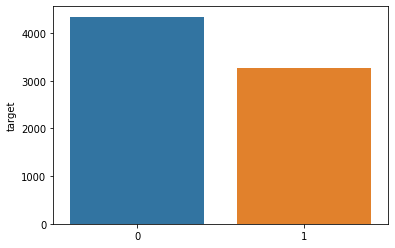

In [35]:
sns.barplot(train['target'].value_counts().index,train['target'].value_counts())

In [36]:
disaster_tweet = train[train['target']==1]['text']
non_disaster_tweet = train[train['target']==0]['text']

In [37]:
disaster_tweet.values[0]

'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all'

In [38]:
non_disaster_tweet.values[1]

'I love fruits'

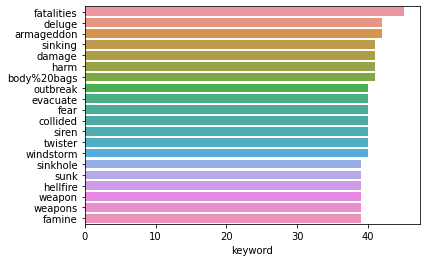

In [39]:
sns.barplot(y = train['keyword'].value_counts()[:20].index,x = train['keyword'].value_counts()[:20] )

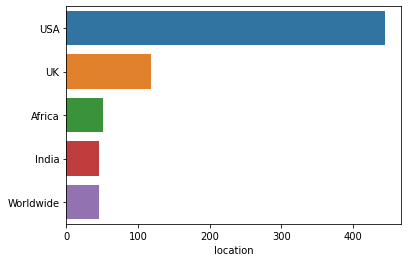

In [40]:
train['location'].replace({'United States':'USA',
                           'New York':'USA',
                            "London":'UK',
                            "Los Angeles, CA":'USA',
                            "Washington, D.C.":'USA',
                            "California":'USA',
                             "Chicago, IL":'USA',
                             "Chicago":'USA',
                            "New York, NY":'USA',
                            "California, USA":'USA',
                            "FLorida":'USA',
                            "Nigeria":'Africa',
                            "Kenya":'Africa',
                            "Everywhere":'Worldwide',
                            "San Francisco":'USA',
                            "Florida":'USA',
                            "United Kingdom":'UK',
                            "Los Angeles":'USA',
                            "Toronto":'Canada',
                            "San Francisco, CA":'USA',
                            "NYC":'USA',
                            "Seattle":'USA',
                            "Earth":'Worldwide',
                            "Ireland":'UK',
                            "London, England":'UK',
                            "New York City":'USA',
                            "Texas":'USA',
                            "London, UK":'UK',
                            "Atlanta, GA":'USA',
                            "Mumbai":"India"},inplace=True)
sns.barplot(y=train['location'].value_counts()[:5].index,x=train['location'].value_counts()[:5])

In [41]:
def clean_text(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

train['text']=train['text'].apply(lambda x:clean_text(x))
test['text']=test['text'].apply(lambda x:clean_text(x))
train['text'][:5]

0    our deeds are the reason of this earthquake ma...
1                forest fire near la ronge sask canada
2    all residents asked to shelter in place are be...
3     people receive wildfires evacuation orders in...
4    just got sent this photo from ruby alaska as s...
Name: text, dtype: object

Text(0.5, 1.0, 'Non-Disaster Tweets')

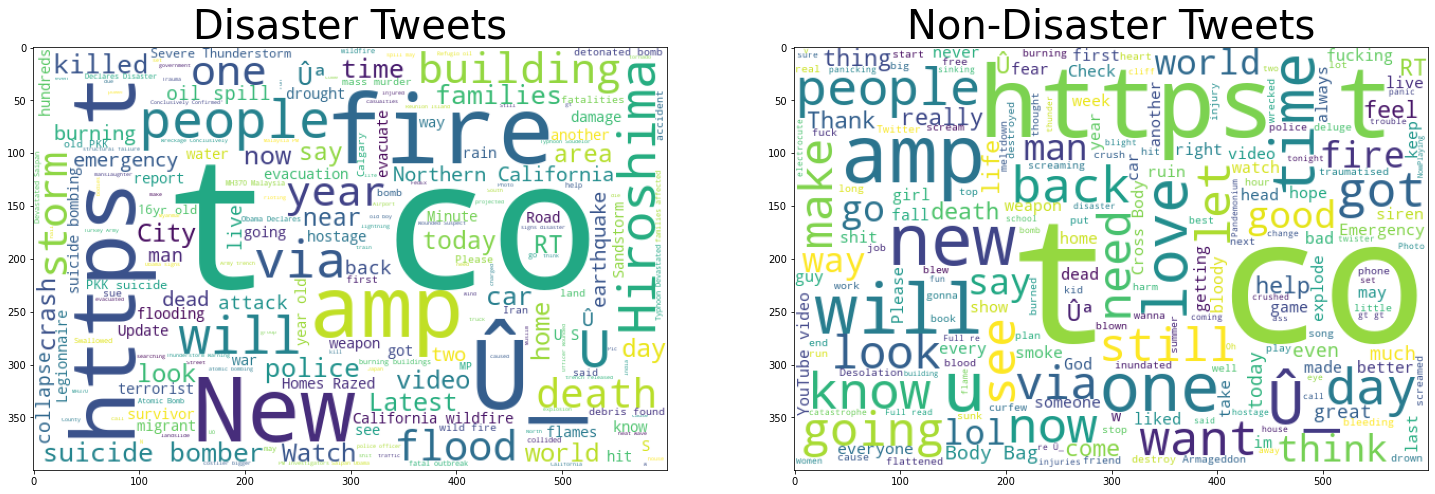

In [42]:
from wordcloud import WordCloud
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = [25,10])

wordcloud1 = WordCloud(background_color = "white",
                      width = 600,
                      height = 400).generate(" ".join(disaster_tweet))
ax1.imshow(wordcloud1)
ax1.set_title("Disaster Tweets", fontsize = 40)

wordcloud2 = WordCloud(background_color = "white",
                      width = 600,
                      height = 400).generate(" ".join(non_disaster_tweet))
ax2.imshow(wordcloud2)
ax2.set_title("Non-Disaster Tweets", fontsize = 40)

In [45]:
tokens =nltk.tokenize.RegexpTokenizer(r'\w+')
train['text']=train['text'].apply(lambda x: tokens.tokenize(x))
test['text']=test['text'].apply(lambda x: tokens.tokenize(x))

In [46]:
train['text'].head()

0    [our, deeds, are, the, reason, of, this, earth...
1        [forest, fire, near, la, ronge, sask, canada]
2    [all, residents, asked, to, shelter, in, place...
3    [people, receive, wildfires, evacuation, order...
4    [just, got, sent, this, photo, from, ruby, ala...
Name: text, dtype: object

In [51]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [52]:
def remove_stopwords(text):
  words=[w for w in text if w not in stopwords.words('english')]
  return words

In [53]:
train['text']=train['text'].apply(lambda x: remove_stopwords(x))
test['text']=test['text'].apply(lambda x: remove_stopwords(x))

In [54]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,"[deeds, reason, earthquake, may, allah, forgiv...",1
1,4,NaN,NaN,"[forest, fire, near, la, ronge, sask, canada]",1
2,5,NaN,NaN,"[residents, asked, shelter, place, notified, o...",1
3,6,NaN,NaN,"[people, receive, wildfires, evacuation, order...",1
4,7,NaN,NaN,"[got, sent, photo, ruby, alaska, smoke, wildfi...",1


In [62]:
def combine_text(list_text):
  combined_text=" ".join(list_text)
  return combined_text

In [63]:
train['text']=train['text'].apply(lambda x: combine_text(x))
test['text']=test['text'].apply(lambda x: combine_text(x))

In [64]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,deeds reason earthquake may allah forgive us,1
1,4,NaN,NaN,forest fire near la ronge sask canada,1
2,5,NaN,NaN,residents asked shelter place notified officer...,1
3,6,NaN,NaN,people receive wildfires evacuation orders cal...,1
4,7,NaN,NaN,got sent photo ruby alaska smoke wildfires pou...,1


In [65]:
count_vectorizer = CountVectorizer()

In [66]:
train_vector=count_vectorizer.fit_transform(train['text'])
test_vector=count_vectorizer.fit_transform(test['text'])

In [69]:
print(train_vector[0].todense())

[[0 0 0 ... 0 0 0]]


In [70]:
count_vectorizer.get_feature_names_out()

array(['aapatwork', 'aaron', 'aarongoodwin', ..., 'ûóstockton', 'ûówe',
       'ûówere'], dtype=object)

In [74]:
print(train_vector.toarray())

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [75]:
tfidf = TfidfVectorizer(min_df = 2, max_df = 0.5, ngram_range=(1,2))
train_tfidf = tfidf.fit_transform(train['text'])
test_tfidf = tfidf.transform(test['text'])

In [76]:
clf = LogisticRegression(C=1.0)
scores = model_selection.cross_val_score(clf,train_vector, train["target"], cv=5, scoring='f1' )
scores

array([0.59865255, 0.49611063, 0.57166948, 0.56290774, 0.68789809])

In [77]:
clf.fit(train_vector, train["target"])

LogisticRegression()

In [78]:
clf_tfidf = LogisticRegression(C=1.0)
scores = model_selection.cross_val_score(clf_tfidf,train_tfidf, train["target"], cv=5, scoring='f1' )
scores

array([0.57229525, 0.49673203, 0.54277829, 0.46618106, 0.64768683])

In [79]:
clf_NB = MultinomialNB()
scores = model_selection.cross_val_score(clf_NB,train_vector, train["target"], cv=5, scoring='f1' )
scores

array([0.63149079, 0.60675773, 0.68575519, 0.64341085, 0.72505092])

In [80]:
clf_NB_tfidf = MultinomialNB()
scores = model_selection.cross_val_score(clf_NB_tfidf,train_tfidf, train["target"], cv=5, scoring='f1' )
scores

array([0.57590597, 0.57092511, 0.61135371, 0.5962963 , 0.7393745 ])

In [81]:
import xgboost as xgb

clf_xgb = xgb.XGBClassifier(max_depth = 7, n_estimators = 200, colsample_bytree = 0.8, subsample = 0.8, nthread = 10, learning_rate = 0.1)
scores = model_selection.cross_val_score(clf_xgb,train_vector, train["target"], cv=5, scoring='f1' )
scores

array([0.47379913, 0.37379576, 0.43988816, 0.38900634, 0.53142857])

In [82]:
import xgboost as xgb

clf_xgb_tfidf = xgb.XGBClassifier(max_depth = 7, n_estimators = 200, colsample_bytree = 0.8, subsample = 0.8, nthread = 10, learning_rate = 0.1)
scores = model_selection.cross_val_score(clf_xgb_tfidf,train_tfidf, train["target"], cv=5, scoring='f1' )
scores

array([0.48947951, 0.34406439, 0.43140965, 0.40084388, 0.53014354])